#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [2]:
!conda activate Seminar_csma
!where python

C:\Users\xinyu\anaconda3\envs\Seminar_csma\python.exe
C:\Users\xinyu\AppData\Local\Programs\Python\Python38\python.exe
C:\Users\xinyu\AppData\Local\Programs\Python\Python37\python.exe
C:\Users\xinyu\AppData\Local\Microsoft\WindowsApps\python.exe


# Install dependencies:

In [3]:
install_packages = True
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



# Imports

In [1]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [2]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [3]:
# Set pandas print options
#This will improve readability of printed pandas dataframe.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [4]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [5]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [6]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [7]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.36772162
n_clusters: 52 silhouette_avg: 0.29523748
n_clusters: 102 silhouette_avg: 0.3156545
n_clusters: 152 silhouette_avg: 0.3043758
n_clusters: 202 silhouette_avg: 0.270761
n_clusters: 252 silhouette_avg: 0.2331129
n_clusters: 302 silhouette_avg: 0.18814617
n_clusters: 352 silhouette_avg: 0.13063547


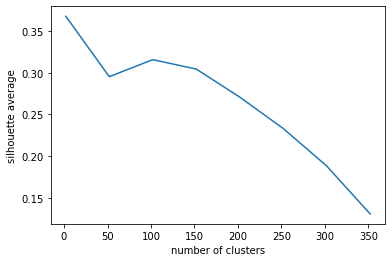

In [8]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

# I changed the number of medoids since the number of samples is less than 1000.
min_clusters=2 
max_clusters=400 
step=50

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

The highest sihouette score is more desirable. We can see that the highest sihouette score is when the number of clusters is 0, but it is clearly not our pursued cluster number. So the seconde best choice in our data sample is around 100 which has a sihouette score around 0.32.

# Clustering with KMedoids

In [10]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 31     1
72     1
78     1
61     1
42     1
22     1
94     1
57     1
8      2
25     2
3      2
26     2
99     2
76     2
97     2
95     2
91     2
87     2
84     2
1      2
82     2
83     2
40     2
48     2
60     2
62     2
65     2
36     2
0      2
77     2
80     2
81     2
71     2
96     3
24     3
88     3
37     3
27     3
19     3
45     3
50     3
98     3
53     3
74     3
68     3
16     3
44     3
89     3
46     3
67     3
2      3
7      3
93     3
30     4
56     4
38     4
41     4
59     4
18     4
63     4
49     4
9      4
90     4
12     4
75     4
6      4
70     4
66     4
92     4
58     5
43     5
20     5
14     5
35     5
4      5
54     5
51     5
79     5
33     6
29     6
86     6
28     6
10     6
15     6
13     7
34     7
23     7
55     7
47     8
85     8
73     8
64     9
52     9
39    10
17    11
5     12
21    13
32    15
69    16
11    16
Name: label_kmedoids, dtype: int64


In [11]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [12]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\Users\xinyu\anaconda3\envs\Seminar_csma\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

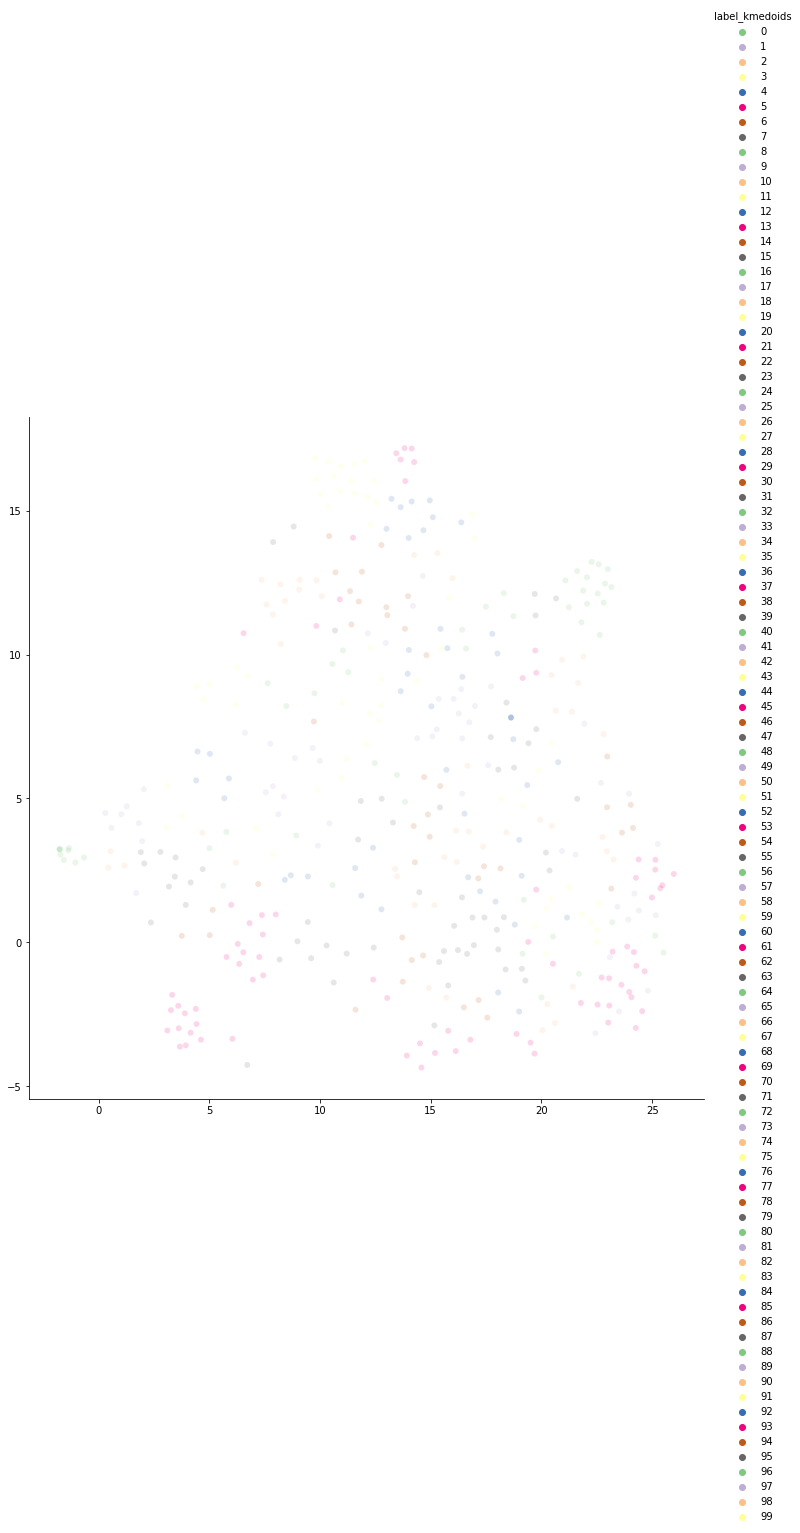

In [13]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

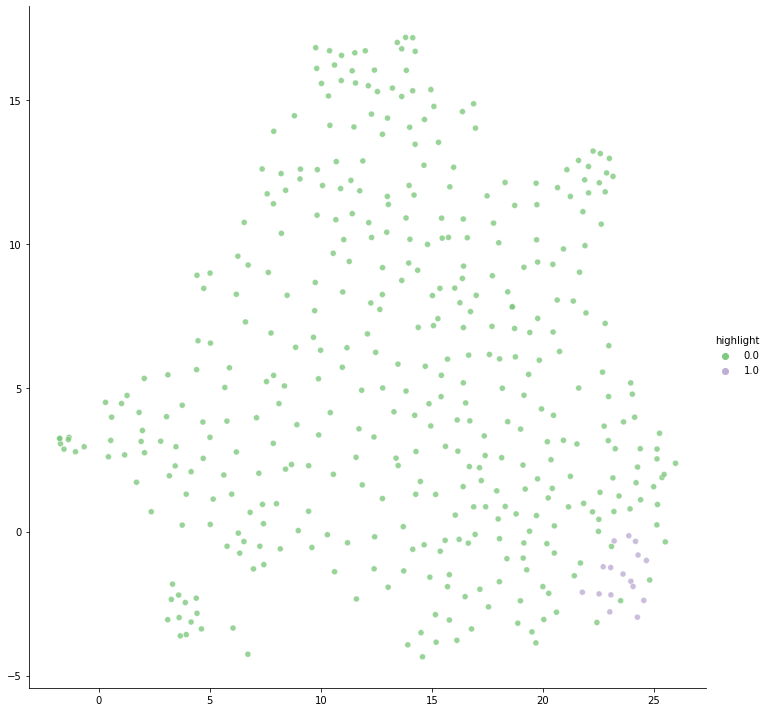

In [15]:
## Choose a cluster to higlight:
cluster_num = 69

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [16]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
263,2019-07-10 17:47:14,disco stu2,It&#39;s a slush fund.. bullshit scam,0,It's a slush fund.. bullshit scam\n\n,-1.0,0,5.960464e-08,0.0
180,2019-07-15 20:51:07,Tom Reid,"METAL NERD Just continuing to show your ignorance. Climate change denial comes in various forms. Some are stupid enough to deny that CO2 is a ghg. Really bloody stupid as it is the presence of atmospheric CO2 that makes this planet habitable. Some deny that Man could possibly emit enough CO2 to change the climate. The facts and fingerprinting prove they’re cretins. And then there are those who deny that there will be a problem from warming. You’re a denier but too stupid to understand the debate in which you are engaged. Next time you look in the mirror, remember, there’s a silly cap with a D on it resting on your think head.",1,"METAL NERD Just continuing to show your ignorance. Climate change denial comes\nin various forms. Some are stupid enough to deny that CO2 is a ghg. Really\nbloody stupid as it is the presence of atmospheric CO2 that makes this planet\nhabitable. Some deny that Man could possibly emit enough CO2 to change the\nclimate. The facts and fingerprinting prove they’re cretins. And then there\nare those who deny that there will be a problem from warming. You’re a denier\nbut too stupid to understand the debate in which you are engaged. Next time\nyou look in the mirror, remember, there’s a silly cap with a D on it resting\non your think head.\n\n",-1.0,1,1.192093e-07,0.0
400,2019-08-27 23:19:25,giovanni smet,"Alex Daniel Hear, hear.",1,"Hear, hear.\n\n",-1.0,2,0.000000e+00,0.0
100,2019-11-17 03:55:08,Ian Wilson,To add to that I would say also search Rowan and Michael Connolly who also have results/graphs from 50 years of data from weather balloons concluding the same that it is atmospheric pressure and that there is no recognized greenhouse effect. https://www.youtube.com/watch?v=XfRBr7PEawY The BBC would never show you the other side of scientific theories that disagree with the popular greenhouse effect.,1,To add to that I would say also search Rowan and Michael Connolly who also\nhave results/graphs from 50 years of data from weather balloons concluding the\nsame that it is atmospheric pressure and that there is no recognized\ngreenhouse effect. The BBC would\nnever show you the other side of scientific theories that disagree with the\npopular greenhouse effect.\n\n,-1.0,3,0.000000e+00,0.0
35,2020-01-05 16:45:27,Don'tTrustPoliticians,"There is no climate change crisis. Check out Tony Heller on YouTube. You will actually see how scientists, governments and government bodies lie and deliberately alter data.",0,"There is no climate change crisis. Check out Tony Heller on YouTube. You will\nactually see how scientists, governments and government bodies lie and\ndeliberately alter data.\n\n",-1.0,4,5.960464e-08,0.0
214,2019-07-15 09:08:25,Gazza,Tom Reid I’m just glad I pissed you off cos you don’t seem to understand the climate 🤪,1,I’m just glad I pissed you off cos you don’t seem to understand the\nclimate 🤪\n\n,-1.0,5,0.000000e+00,0.0
357,2019-10-10 07:26:24,TheKopfstand,@Stwinge44 Dude it does not matter. Science is not about consensus. I bet you are no scientist dont you?,1,@ Dude it does not matter. Science is not about consensus. I bet you\nare no scientist dont you?\n\n,-1.0,6,0.000000e+00,0.0
331,2019-07-10 16:31:49,Common Sense,"foxbat51 a lot of people don’t believe anything liberals or scientists tell them as they lie so often to ensure funding. Scientists in the pocket of Junk food manufacturers lie for them by telling us their products are good for us. We’ve also been told that high carbohydrate diets are good for us, they have fuelled obesity. The cover up by the establishment of the rape of thousands of girls by Muslim men, the list is endless. For me I have seen the increase in temperature over the last 50 years, I have also expe

In [17]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  2 mean distance from center:  0.000616908073425293 Proportion of replies: 50.0
1 number of samples:  2 mean distance from center:  0.0006705522537231445 Proportion of replies: 100.0
2 number of samples:  3 mean distance from center:  0.00030795733891864074 Proportion of replies: 66.66666666666667
3 number of samples:  2 mean distance from center:  0.000616908073425293 Proportion of replies: 50.0
4 number of samples:  5 mean distance from center:  0.0011909008208021987 Proportion of replies: 0.0
5 number of samples:  12 mean distance from center:  0.0010306636795576196 Proportion of replies: 100.0
6 number of samples:  4 mean distance from center:  0.0011488795280456543 Proportion of replies: 100.0
7 number of samples:  3 mean distance from center:  0.0006874402515677502 Proportion of replies: 100.0
8 number of samples:  2 mean distance from center:  0.00042319297790527344 Proportion of replies: 100.0
9 number of samples:  4 mean distance from center:  0.0012859702

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

The most clusters in my data only include less than 5 comments, so I choose the two clusters with most number of comments: cluster 11 and cluster 69 with each 16 comments. 

In [18]:
# Choose a cluster to print
cluster_number =   11
# Choose the number of samples to print
number_of_samples_to_print = 16

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 16
Average Distance from cluster center: 8.165836e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
120,2019-07-13 15:17:20,Michael Nolte,British Bull Crap corporation at it again. Its now the mouth piece of the fascist police state that the UK is becoming.,0,British Bull Crap corporation at it again. Its now the mouth piece of the\nfascist police state that the UK is becoming.\n\n,-1.0,11,1.788139e-07,0.0
96,2019-07-31 08:01:36,mark o,"Psy op cover up ! Anybody who believes the BBC needs to fact check for themselves like I did , there using children for guilty emotion and forget about facts . They did the same with WMD&#39;S and Saville!<br />And the worst thing is most actually believe them ! WAKE UP!",0,"Psy op cover up ! Anybody who believes the BBC needs to fact check for\nthemselves like I did , there using children for guilty emotion and forget\nabout facts . They did the same with WMD'S and Saville! \nAnd the worst thing is most actually believe them ! WAKE UP!\n\n",-1.0,11,2.563000e-06,0.0
339,2019-07-10 15:59:33,gilkesisking,"They got the media to do it. Case in point, the BBC and its anti Brexit agenda. Playing the public is getting hard to do these days thanks to the internet. Unfortunately, its why governments attack and ever more deeply try to control online space. Propaganda for agenda, education for a select few. its hardly a new thing.",0,"They got the media to do it. Case in point, the BBC and its anti Brexit\nagenda. Playing the public is getting hard to do these days thanks to the\ninternet. Unfortunately, its why governments attack and ever more deeply try\nto control online space. Propaganda for agenda, education for a select few.\nits hardly a new thing.\n\n",-1.0,11,3.755093e-06,0.0
140,2019-07-12 09:21:20,luke green,"Being as the bbc is now nothing more than a propaganda outlet allied with a cabal of criminals determined to push lies to change the very fabric of society, ill do its job for it and link you all to an accurate analysis of these emails IT DOESNT MATTER HOW YOU ARRANGE THEM FOLKS! <a href=""https://www.lavoisier.com.au/articles/greenhouse-science/climate-change/climategate-emails.pdf"">https://www.lavoisier.com.au/articles/greenhouse-science/climate-change/climategate-emails.pdf</a>",0,"Being as the bbc is now nothing more than a propaganda outlet allied with a\ncabal of criminals determined to push lies to change the very fabric of\nsociety, ill do its job for it and link you all to an accurate analysis of\nthese emails IT DOESNT MATTER HOW YOU ARRANGE THEM FOLKS!\n\nchange/climategate-emails.pdf\n\n",-1.0,11,4.649162e-06,0.0
39,2020-05-15 19:01:19,pricture,"*""The BBC Exposed""* by The Corbett Report is worth a watch.",1,"*""The BBC Exposed""* by The Corbett Report is worth a watch.\n\n",-1.0,11,6.020069e-06,0.0
36,2020-01-01 10:28:49,Colin W,BBC is a propaganda source and nothing more.,0,BBC is a propaganda source and nothing more.\n\n,-1.0,11,6.079674e-06,0.0
38,2019-12-22 12:37:23,Em Dee,Remember when the BBC was a credible news station. No I don&#39;t either.,0,Remember when the BBC was a credible news station. No I don't either.\n\n,-1.0,11,6.139278e-06,0.0
137,2019-07-13 09:42:15,S Gardner,"The so+called progressives also used nudge theory, the BBC, etc to make us fall for vile social change",0,"The so+called progressives also used nudge theory, the BBC, etc to make us\nfall for vile social change\n\n",-1.0,11,7.510185e-06,0.0
44,2019-12-14 15:44:00,OK A&M '86,"Hahhahaha, what a joke! Boris Johnson should now kill off the BBC while Trump kills off PBS. Why should taxpayer money support such one-sided drivel!",0,"Hahhahaha, what a joke! Boris Johnson should now kill off the BBC while Trump\nkills off PBS. Why should taxpayer money support such one-sided drivel!\n\n",-1.0,11,8.225441e-06,0.0
72,2019-11-17 03:23:41,Ian Wilson,"I haven&#39;t been able to see the full documentary as yet but this 10-minute video tells me enough that the BBC haven&#39;t done their research into what was h

In [19]:
# Choose a cluster to print
cluster_number =   69
# Choose the number of samples to print
number_of_samples_to_print = 16

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 16
Average Distance from cluster center: 9.283423e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
280,2019-07-14 13:38:04,GEORGELET4,@Scott Koontz There was much more Arctic ice melt in the first half of the 20th century based on scientist and newspaper reports. The temperatures are very suspect - depending on out of the way places and heat island effects. Ice melt and sea level rise (look at NOAA tide charts) do not correlate with fossil fuel CO2. The claims of more extreme weather are totally bogus.,1,@ There was much more Arctic ice melt in the first half of the\n20th century based on scientist and newspaper reports. The temperatures are\nvery suspect - depending on out of the way places and heat island effects. Ice\nmelt and sea level rise (look at NOAA tide charts) do not correlate with\nfossil fuel CO2. The claims of more extreme weather are totally bogus.\n\n,-1.0,69,0.000000,1.0
368,2019-07-17 12:26:24,Alexander Stephens,@Tom Reid the fingerprints left behind in time are small and generally gained from ice core samples - which limits the understanding to polar regions. Ocean current shifts and/or solar output increase are the most likely triggers. Snowballing effects to enhance the warming with albedo decrease and also large Methane release. this warming trend almost reversed in the next millenium (as you will now have seen). Only to restart again. No cataclysm of sufficient extent has been identified to co-incide with this - and because it's so recent (comparitively speaking) none will be.,1,@ the fingerprints left behind in time are small and generally gained\nfrom ice core samples - which limits the understanding to polar regions. Ocean\ncurrent shifts and/or solar output increase are the most likely triggers.\nSnowballing effects to enhance the warming with albedo decrease and also large\nMethane release. this warming trend almost reversed in the next millenium (as\nyou will now have seen). Only to restart again. No cataclysm of sufficient\nextent has been identified to co-incide with this - and because it's so recent\n(comparitively speaking) none will be.\n\n,-1.0,69,0.000001,1.0
152,2019-07-13 12:25:02,kitemanmusic,The North Pole ice sheet floats and if it melts it does not affect sea level. Check this.,1,The North Pole ice sheet floats and if it melts it does not affect sea level.\nCheck this.\n\n,-1.0,69,0.000003,1.0
379,2019-07-13 12:26:02,kitemanmusic,"Who caused the Ice Ages? Not me, or anyone else.",1,"Who caused the Ice Ages? Not me, or anyone else.\n\n",-1.0,69,0.000005,1.0
79,2019-11-01 14:59:00,Kenneth Peartree,"I guess the cars and factories caused the last ice age too, right? Perhaps 11,000 years ago when global temps started rising to end the last ice age, human made C02 cause that as well, right? The shift in the magnetic poles have weakened the protective layers of the ionosphere allowing more of the sun’s rays to heat up oceans, boiling off more of that largest storehouse of C02, releasing it into the atmosphere. It is the sun that is causing temps to rise, dah. This is not new information, just information that you have been taught to ignore. Google &quot;The Adam and Eve Story&quot; to learn what they don&#39;t want you to know about what is about to happen. Ask just one question when you find it. Why did the CIA classify this book? Wake up sheeple!",0,"I guess the cars and factories caused the last ice age too, right? Perhaps\n11,000 years ago when global temps started rising to end the last ice age,\nhuman made C02 cause that as well, right? The shift in the magnetic poles have\nweakened the protective layers of the ionosphere allowing more of the sun’s\nrays to heat up oceans, boiling off more of that largest storehouse of C02,\nreleasing it into the atmosphere. It is the sun that is causing temps to rise,\ndah. This is not new information, just information that you have been taught\nto ignore. Google ""The Adam and Eve Story"" to learn what they don't want you\nto know about what is abou

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [20]:
#which cluster would you like to assign labels to?
cluster_number = 11
#your label
label_manual = 'expressions including BBC'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [21]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
120,2019-07-13 15:17:20,Michael Nolte,British Bull Crap corporation at it again. Its now the mouth piece of the fascist police state that the UK is becoming.,0,British Bull Crap corporation at it again. Its now the mouth piece of the\nfascist police state that the UK is becoming.\n\n,expressions including BBC,11,1.788139e-07,0.0
96,2019-07-31 08:01:36,mark o,"Psy op cover up ! Anybody who believes the BBC needs to fact check for themselves like I did , there using children for guilty emotion and forget about facts . They did the same with WMD&#39;S and Saville!<br />And the worst thing is most actually believe them ! WAKE UP!",0,"Psy op cover up ! Anybody who believes the BBC needs to fact check for\nthemselves like I did , there using children for guilty emotion and forget\nabout facts . They did the same with WMD'S and Saville! \nAnd the worst thing is most actually believe them ! WAKE UP!\n\n",expressions including BBC,11,2.563000e-06,0.0
339,2019-07-10 15:59:33,gilkesisking,"They got the media to do it. Case in point, the BBC and its anti Brexit agenda. Playing the public is getting hard to do these days thanks to the internet. Unfortunately, its why governments attack and ever more deeply try to control online space. Propaganda for agenda, education for a select few. its hardly a new thing.",0,"They got the media to do it. Case in point, the BBC and its anti Brexit\nagenda. Playing the public is getting hard to do these days thanks to the\ninternet. Unfortunately, its why governments attack and ever more deeply try\nto control online space. Propaganda for agenda, education for a select few.\nits hardly a new thing.\n\n",expressions including BBC,11,3.755093e-06,0.0
140,2019-07-12 09:21:20,luke green,"Being as the bbc is now nothing more than a propaganda outlet allied with a cabal of criminals determined to push lies to change the very fabric of society, ill do its job for it and link you all to an accurate analysis of these emails IT DOESNT MATTER HOW YOU ARRANGE THEM FOLKS! <a href=""https://www.lavoisier.com.au/articles/greenhouse-science/climate-change/climategate-emails.pdf"">https://www.lavoisier.com.au/articles/greenhouse-science/climate-change/climategate-emails.pdf</a>",0,"Being as the bbc is now nothing more than a propaganda outlet allied with a\ncabal of criminals determined to push lies to change the very fabric of\nsociety, ill do its job for it and link you all to an accurate analysis of\nthese emails IT DOESNT MATTER HOW YOU ARRANGE THEM FOLKS!\n\nchange/climategate-emails.pdf\n\n",expressions including BBC,11,4.649162e-06,0.0
39,2020-05-15 19:01:19,pricture,"*""The BBC Exposed""* by The Corbett Report is worth a watch.",1,"*""The BBC Exposed""* by The Corbett Report is worth a watch.\n\n",expressions including BBC,11,6.020069e-06,0.0
36,2020-01-01 10:28:49,Colin W,BBC is a propaganda source and nothing more.,0,BBC is a propaganda source and nothing more.\n\n,expressions including BBC,11,6.079674e-06,0.0
38,2019-12-22 12:37:23,Em Dee,Remember when the BBC was a credible news station. No I don&#39;t either.,0,Remember when the BBC was a credible news station. No I don't either.\n\n,expressions including BBC,11,6.139278e-06,0.0
137,2019-07-13 09:42:15,S Gardner,"The so+called progressives also used nudge theory, the BBC, etc to make us fall for vile social change",0,"The so+called progressives also used nudge theory, the BBC, etc to make us\nfall for vile social change\n\n",expressions including BBC,11,7.510185e-06,0.0
44,2019-12-14 15:44:00,OK A&M '86,"Hahhahaha, what a joke! Boris Johnson should now kill off the BBC while Trump kills off PBS. Why should taxpayer money support such one-sided drivel!",0,"Hahhahaha, what a joke! Boris Johnson should now kill off the BBC while Trump\nkills off PBS. Why should taxpayer money support such one-sided drivel!\n\n",expressions including BBC,11,8.225441e-06,0.0
72,201

In [22]:
#which cluster would you like to assign labels to?
cluster_number = 69
#your label
label_manual = 'real talk around climate change'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [23]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
280,2019-07-14 13:38:04,GEORGELET4,@Scott Koontz There was much more Arctic ice melt in the first half of the 20th century based on scientist and newspaper reports. The temperatures are very suspect - depending on out of the way places and heat island effects. Ice melt and sea level rise (look at NOAA tide charts) do not correlate with fossil fuel CO2. The claims of more extreme weather are totally bogus.,1,@ There was much more Arctic ice melt in the first half of the\n20th century based on scientist and newspaper reports. The temperatures are\nvery suspect - depending on out of the way places and heat island effects. Ice\nmelt and sea level rise (look at NOAA tide charts) do not correlate with\nfossil fuel CO2. The claims of more extreme weather are totally bogus.\n\n,real talk around climate change,69,0.000000,1.0
368,2019-07-17 12:26:24,Alexander Stephens,@Tom Reid the fingerprints left behind in time are small and generally gained from ice core samples - which limits the understanding to polar regions. Ocean current shifts and/or solar output increase are the most likely triggers. Snowballing effects to enhance the warming with albedo decrease and also large Methane release. this warming trend almost reversed in the next millenium (as you will now have seen). Only to restart again. No cataclysm of sufficient extent has been identified to co-incide with this - and because it's so recent (comparitively speaking) none will be.,1,@ the fingerprints left behind in time are small and generally gained\nfrom ice core samples - which limits the understanding to polar regions. Ocean\ncurrent shifts and/or solar output increase are the most likely triggers.\nSnowballing effects to enhance the warming with albedo decrease and also large\nMethane release. this warming trend almost reversed in the next millenium (as\nyou will now have seen). Only to restart again. No cataclysm of sufficient\nextent has been identified to co-incide with this - and because it's so recent\n(comparitively speaking) none will be.\n\n,real talk around climate change,69,0.000001,1.0
152,2019-07-13 12:25:02,kitemanmusic,The North Pole ice sheet floats and if it melts it does not affect sea level. Check this.,1,The North Pole ice sheet floats and if it melts it does not affect sea level.\nCheck this.\n\n,real talk around climate change,69,0.000003,1.0
379,2019-07-13 12:26:02,kitemanmusic,"Who caused the Ice Ages? Not me, or anyone else.",1,"Who caused the Ice Ages? Not me, or anyone else.\n\n",real talk around climate change,69,0.000005,1.0
79,2019-11-01 14:59:00,Kenneth Peartree,"I guess the cars and factories caused the last ice age too, right? Perhaps 11,000 years ago when global temps started rising to end the last ice age, human made C02 cause that as well, right? The shift in the magnetic poles have weakened the protective layers of the ionosphere allowing more of the sun’s rays to heat up oceans, boiling off more of that largest storehouse of C02, releasing it into the atmosphere. It is the sun that is causing temps to rise, dah. This is not new information, just information that you have been taught to ignore. Google &quot;The Adam and Eve Story&quot; to learn what they don&#39;t want you to know about what is about to happen. Ask just one question when you find it. Why did the CIA classify this book? Wake up sheeple!",0,"I guess the cars and factories caused the last ice age too, right? Perhaps\n11,000 years ago when global temps started rising to end the last ice age,\nhuman made C02 cause that as well, right? The shift in the magnetic poles have\nweakened the protective layers of the ionosphere allowing more of the sun’s\nrays to heat up oceans, boiling off more of that largest storehouse of C02,\nreleasing it into the atmosphere. It is the sun that is causing temps to rise,\ndah. This is not new information, just information that you have been taught